In [1]:
# Global settings and imports
import os
import random
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten

from ann_visualizer.visualize import ann_viz
import graphviz
import matplotlib.pyplot as plt
from PIL import Image

pd.set_option("display.max_colwidth", 200)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Disable warnings
random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In [2]:
# 1. FULLY CONNECTED FEED-FORWARD NEURAL NETWORK (FCNN)
# Load dataset:     https://www.kaggle.com/datasets/sujithmandala/credit-score-classification-dataset
file_dataset = "input/credit_score.csv"
data = pd.read_csv(file_dataset, encoding = "latin-1")
feature_names = {
    "Age": "age",
    "Gender": "sex",
    "Income": "income",
    "Education": "educ",
    "Marital Status": "married",
    "Number of Children": "child",
    "Home Ownership": "house",
    "Credit Score": "score"}
data = data.rename(columns = feature_names)
print("Raw data:")
data.info()
print(f"\n{data.head()}\n")

# Split dataset into training set and test set
X = data.drop("score", axis = 1)
y = data["score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

Raw data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   age      164 non-null    int64 
 1   sex      164 non-null    object
 2   income   164 non-null    int64 
 3   educ     164 non-null    object
 4   married  164 non-null    object
 5   child    164 non-null    int64 
 6   house    164 non-null    object
 7   score    164 non-null    object
dtypes: int64(3), object(5)
memory usage: 10.4+ KB

   age     sex  income                 educ  married  child   house score
0   25  Female   50000    Bachelor's Degree   Single      0  Rented  High
1   30    Male  100000      Master's Degree  Married      2   Owned  High
2   35  Female   75000            Doctorate  Married      1   Owned  High
3   40    Male  125000  High School Diploma   Single      0   Owned  High
4   45  Female  100000    Bachelor's Degree  Married      3   Owned  High



In [3]:
# Normalization
# Do minmax for all numerical features
scaler = MinMaxScaler()
num_cols = X_train.select_dtypes(include = [np.number]).columns.tolist()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Do ordinal encoding for education feature
order = ["High School Diploma",
         "Associate's Degree",
         "Bachelor's Degree",
         "Master's Degree",
         "Doctorate"]
oe = OrdinalEncoder(categories = [order], dtype = np.int32)
X_train[["educ"]] = oe.fit_transform(X_train[["educ"]])
X_test[["educ"]] = oe.transform(X_test[["educ"]])

# Do ordinal encoding for score (target)
order = ["Low",
         "Average",
         "High"]
oe = OrdinalEncoder(categories = [order], dtype = np.int32)
y_train = oe.fit_transform(y_train.values.reshape(-1, 1))
y_train = pd.Series(y_train.flatten(), name = "score")
y_test = oe.transform(y_test.values.reshape(-1, 1))
y_test = pd.Series(y_test.flatten(), name = "score")

# Do label encoding for categorical nominal features
le = LabelEncoder()
obj_cols = X_train.select_dtypes(include = ["object"]).columns.tolist()
for col in obj_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
le_map = {label: index for index, label in enumerate(le.classes_)}
print(f"Label mapping:      {le_map}")

print("\nNormalized data:")
X_train.info()
print(f"\n{X_train.head()}\n")
print(y_train)

Label mapping:      {'Owned': 0, 'Rented': 1}

Normalized data:
<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 97 to 9
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      131 non-null    float64
 1   sex      131 non-null    int32  
 2   income   131 non-null    float64
 3   educ     131 non-null    int32  
 4   married  131 non-null    int32  
 5   child    131 non-null    float64
 6   house    131 non-null    int32  
dtypes: float64(3), int32(4)
memory usage: 6.1 KB

          age  sex    income  educ  married     child  house
97   0.714286    0  0.686275     2        0  1.000000      0
128  0.107143    1  0.372549     2        1  0.000000      1
141  0.035714    0  0.137255     1        1  0.000000      1
69   0.392857    0  0.490196     3        0  0.666667      0
2    0.357143    0  0.372549     4        0  0.333333      0

0      2
1      1
2      1
3      2
4      2
      ..
126    2
127    2
128   

In [4]:
# Create model of FCNN
activation = "tanh"  # Hyperbolic tan():                у = tanh(x)
kernel_init = "uniform"
model = Sequential([  # New linear stack of layers
    Input(shape = len(X_train.columns)),  # Number of features
    Dense(
        units = 6,  # Number of neurons in a layer
        kernel_initializer = kernel_init,  # The weights of neurons
        activation = activation,
    ),
    Dense(units = 5, kernel_initializer = kernel_init, activation = activation),
    Dense(
        units = 3,  # Num of neurons = num of classes
        kernel_initializer = kernel_init,
        activation = "softmax"  # softmax() ~ argmax(f(x)):     if max(f(x0)) {return x0}
    )
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 48        
                                                                 
 dense_1 (Dense)             (None, 5)                 35        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 101 (404.00 Byte)
Trainable params: 101 (404.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# Compile and fit FCNN
def estimate_accuracy(X_test, y_test, y_pred):
    loss, accuracy = model.evaluate(X_test, y_test, verbose = 0)
    print("\n")
    print(f"Test loss:          {loss}")
    print(f"Test accuracy:      {accuracy}\n")

    # Convert probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis = 1)
    print(classification_report(y_test, y_pred_labels))
    print(confusion_matrix(y_test, y_pred_labels))


model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",  # Use it with integer encoded labels. Don't use it with one-hot encoded labels.
    metrics = ["accuracy"]
)
model.fit(
    X_train,
    y_train,
    batch_size = 10,  # Model weights will be updated after every 10 samples
    epochs = 25  # Number o iterations over the entire X_train and y_train data provided
)
y_pred = model.predict(X_test)
estimate_accuracy(X_test, y_test, y_pred)


Epoch 1/25


14/14 [==============================] - 1s 2ms/step - loss: 1.0945 - accuracy: 0.6260
Epoch 2/25
14/14 [==============================] - 0s 2ms/step - loss: 1.0832 - accuracy: 0.6947
Epoch 3/25
14/14 [==============================] - 0s 1ms/step - loss: 1.0691 - accuracy: 0.6947
Epoch 4/25
14/14 [==============================] - 0s 1ms/step - loss: 1.0463 - accuracy: 0.6947
Epoch 5/25
14/14 [==============================] - 0s 1ms/step - loss: 1.0066 - accuracy: 0.6947
Epoch 6/25
14/14 [==============================] - 0s 1ms/step - loss: 0.9493 - accuracy: 0.6947
Epoch 7/25
14/14 [==============================] - 0s 1ms/step - loss: 0.8832 - accuracy: 0.6947
Epoch 8/25
14/14 [==============================] - 0s 1ms/step - loss: 0.8195 - accuracy: 0.6947
Epoch 9/25
14/14 [==============================] - 0s 2ms/step - loss: 0.7601 - accuracy: 0.6947
Epoch 10/25
14/14 [==============================] - 0s 1ms/step - loss: 0.7142 - accuracy: 0.6947
Epoch 11/25
14/1

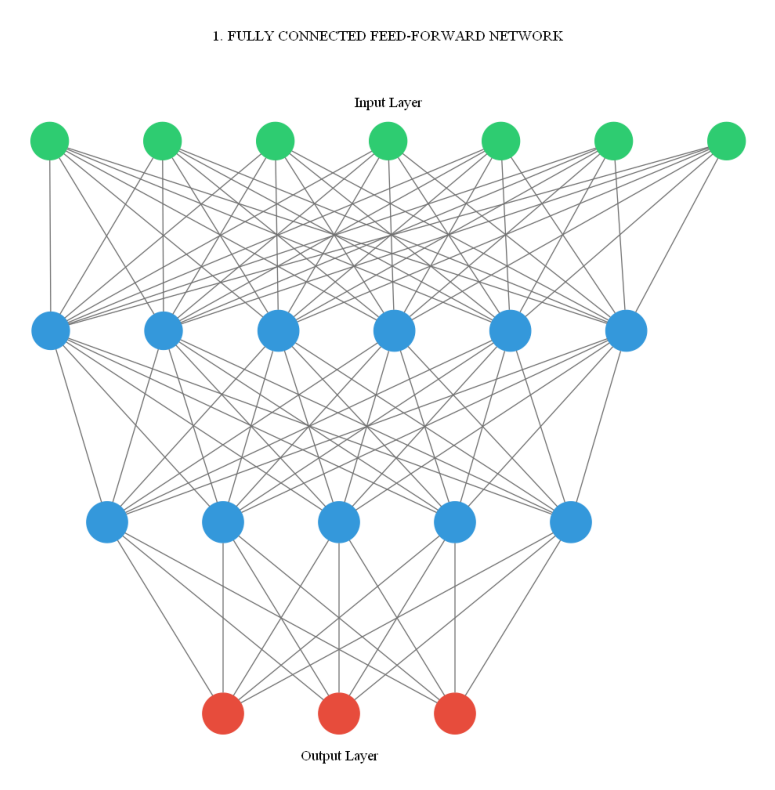

In [6]:
# Visualize FCNN
# Save model to .gv file. Read graph from .gv
file_fcnn = "output/fcnn"
ann_viz(model, view = True, filename = f"{file_fcnn}.gv", title = "1. FULLY CONNECTED FEED-FORWARD NETWORK")
graph_file = graphviz.Source.from_file(f"{file_fcnn}.gv")

# Render the .gv to a .png, save image to file. Print image
graph_file.render(filename = file_fcnn, format = "png", cleanup = True)
model_jpg = Image.open(f"{file_fcnn}.png")
plt.figure(figsize = (10, 10))
plt.imshow(model_jpg)
plt.axis("off")
plt.show()

In [7]:
# 2. CONVOLUTIONAL NEURAL NETWORK (CNN)
# Load dataset:     https://www.kaggle.com/datasets/gpiosenka/iconic-wwii-aircraft-imagesclassification?select=airplanes.csv
dir_dataset = "input/ww2_aircrafts"
file_dataset = f"{dir_dataset}/airplanes.csv"
data = pd.read_csv(file_dataset, encoding = "latin-1")
feature_names = {
    "class id": "id",
    "filepaths": "filepath",
    "labels": "label",
    "data set": "set"}
data = data.rename(columns = feature_names)
data = data.drop(["id", "set"], axis = 1)

# Reduce number of classes to 3
labels = ["Boeing P-26 Peashooter", "Grumman F7F Tigercat", "Supermarine Spitfire"]
data = data[data["label"].isin(labels)]
input_shape = (224, 224, 3)
print(f"JPG resolution = {input_shape[0]} x {input_shape[1]} p, depth = {input_shape[2]}")

JPG resolution = 224 x 224 p, depth = 3


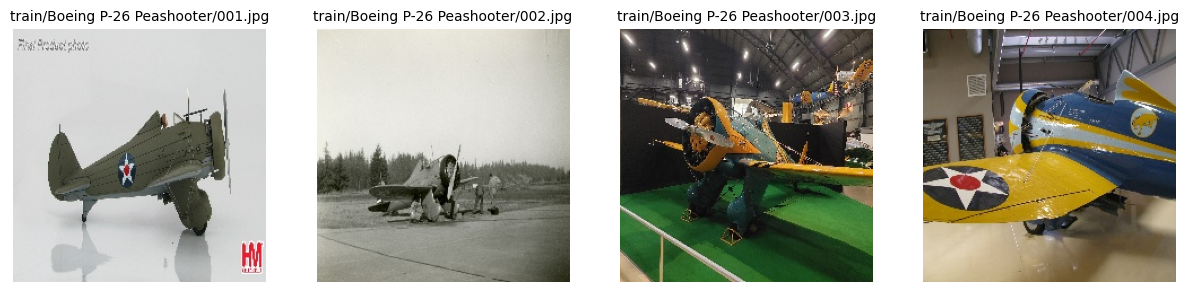

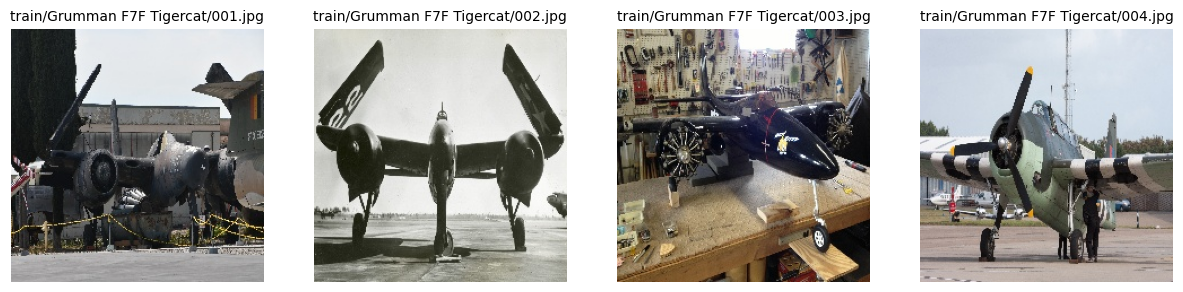

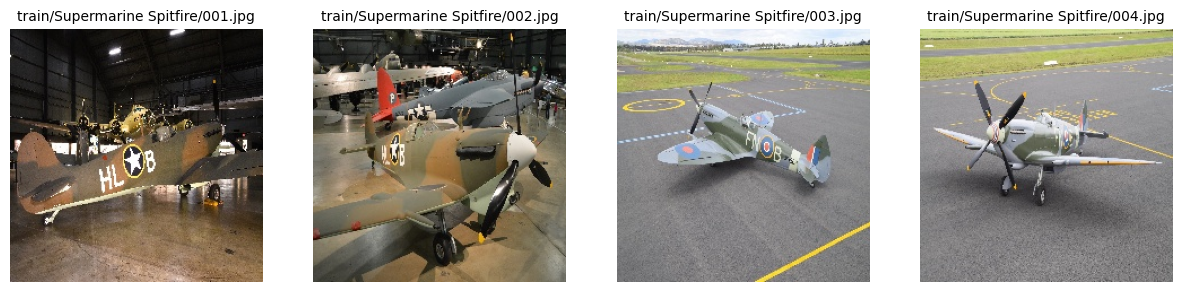

In [8]:
# Print few images of every class
def display_images(images):
    cols = len(images)
    plt.figure(figsize = (15, 15))
    for i, (filepath, image) in enumerate(images.items()):
        plt.subplot(1, cols, i + 1)
        plt.imshow(image)
        plt.title(f"{filepath}", fontsize = 10)
        plt.axis("off")
    plt.show()


for label in labels:
    images = {}
    n_images = 4
    filepaths = data[data["label"] == label]["filepath"].iloc[:n_images]
    for filepath in filepaths:
        file_jpg = f"{dir_dataset}/{filepath}"
        image = Image.open(file_jpg)
        images[filepath] = image
    display_images(images)

In [10]:
# Read images from JPG files
def read_images(df):
    X = []
    y = []
    for index, row in df.iterrows():
        file_jpg = f"{dir_dataset}/{row['filepath']}"
        image = Image.open(file_jpg)
        image = np.array(image, dtype = np.float32) / 255
        if image.shape == input_shape:
            X.append(image)
            y.append(row["label"])
    return np.array(X), np.array(y)

# Split dataset into training set and test set
X, y = read_images(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Do label encoding for classes
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
le_map = {label: index for index, label in enumerate(le.classes_)}
print(f"\nLabel mapping:      {le_map}")

X_train shape: (672, 224, 224, 3)
X_test shape: (168, 224, 224, 3)

Label mapping:      {'Boeing P-26 Peashooter': 0, 'Grumman F7F Tigercat': 1, 'Supermarine Spitfire': 2}


In [11]:
# Create model of CNN
activation = "relu"  # Rectified linear unit:           if (x > 0) {return x} else {return 0}
model = Sequential(
    [
        Input(shape = input_shape),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = activation),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = activation),
        MaxPooling2D(pool_size = (2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(units = len(labels), activation = "softmax")
    ]
)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dropout (Dropout)           (None, 186624)          

In [12]:
# Compile and fit CNN
model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)
model.fit(X_train, y_train, batch_size = 128, epochs = 12, validation_split = 0.1)
y_pred = model.predict(X_test)
estimate_accuracy(X_test, y_test, y_pred)

Epoch 1/12
5/5 [==============================] - 8s 1s/step - loss: 3.1653 - accuracy: 0.3642 - val_loss: 1.9848 - val_accuracy: 0.2647
Epoch 2/12
5/5 [==============================] - 7s 1s/step - loss: 1.3206 - accuracy: 0.3228 - val_loss: 1.0305 - val_accuracy: 0.3971
Epoch 3/12
5/5 [==============================] - 7s 1s/step - loss: 0.9715 - accuracy: 0.5596 - val_loss: 0.9252 - val_accuracy: 0.6324
Epoch 4/12
5/5 [==============================] - 7s 1s/step - loss: 0.8578 - accuracy: 0.6060 - val_loss: 0.8200 - val_accuracy: 0.6029
Epoch 5/12
5/5 [==============================] - 7s 1s/step - loss: 0.7171 - accuracy: 0.7169 - val_loss: 0.7507 - val_accuracy: 0.6471
Epoch 6/12
5/5 [==============================] - 7s 1s/step - loss: 0.5988 - accuracy: 0.7848 - val_loss: 0.7116 - val_accuracy: 0.6765
Epoch 7/12
5/5 [==============================] - 7s 1s/step - loss: 0.4838 - accuracy: 0.8245 - val_loss: 0.7682 - val_accuracy: 0.6912
Epoch 8/12
5/5 [=========================

Layer #0:   conv2d (3, 3, 3, 32)


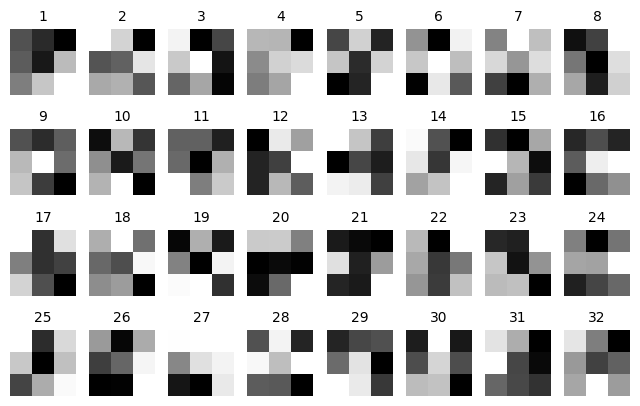

In [13]:
# Visualize CNN
n_layer = 0
layer = model.layers[n_layer]
filters, biases = layer.get_weights()
print(f"Layer #{n_layer}:   {layer.name} {filters.shape}")

# Show filters
cols = 8
rows = int(filters.shape[-1] / cols)
n_filters = cols * rows
plt.figure(figsize = (cols, rows + 1))
for i in range(1, n_filters + 1):
    f = filters[:, :, :, i - 1]
    plt.subplot(rows, cols, i)
    plt.imshow(f[:, :, 0], cmap = "gray")
    plt.title(f"{i}", fontsize = 10)
    plt.axis("off")
plt.show()

In [14]:
# 3. RECURRENT NEURAL NETWORK (RNN)
# Load dataset:     https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text
file_dataset = "input/tweet_emotions.csv"
data = pd.read_csv(file_dataset, encoding = "latin-1")
data = data.drop("tweet_id", axis = 1)
feature_names = {
    "sentiment": "mood",
    "content": "text"}
data = data.rename(columns = feature_names)
data.info()

unique_vals = data["mood"].unique()
print(f"\nUnique vals in 'mood' col: {unique_vals}")
chosen_moods = ["hate", "sadness", "relief"]
data = data[data["mood"].isin(chosen_moods)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mood    40000 non-null  object
 1   text    40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB

Unique vals in 'mood' col: ['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [15]:
import nltk

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


# Preprocess dataset
def clean_text(text):
    tokens = word_tokenize(text)  # Split text into tokens

    # Remove punctuation, convert to lower case, clean stop words
    stop_words = stopwords.words("english")
    words = []
    for token in tokens:
        if token.isalpha():
            word = token.lower()
            if word not in stop_words:
                words.append(word)

    # Perform stemming
    stemmer = PorterStemmer()
    stemmed_words = []
    for word in words:
        stemmed_word = stemmer.stem(word)
        stemmed_words.append(stemmed_word)
    stemmed_text = " ".join(stemmed_words)

    return stemmed_text

data_before = data.copy()
data["text"] = data["text"].apply(clean_text)
display(data_before.head(6))
display(data.head(6))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lol19\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lol19\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lol19\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,mood,text
1,sadness,Layin n bed with a headache ughhhh...waitin on your call...
2,sadness,Funeral ceremony...gloomy friday...
6,sadness,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"
8,sadness,@charviray Charlene my love. I miss you
9,sadness,@kelcouch I'm sorry at least it's Friday?
12,sadness,Ugh! I have to beat this stupid song to get to the next rude!


,mood,text
1,sadness,layin n bed headach ughhhh waitin call
2,sadness,funer ceremoni gloomi friday
6,sadness,sleep im think old friend want marri damn amp want scandal
8,sadness,charviray charlen love miss
9,sadness,kelcouch sorri least friday
12,sadness,ugh beat stupid song get next rude
